In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm.notebook import tqdm
from PIL import Image
from torchvision.utils import make_grid
import torch.optim as optim
import seaborn as sns
# import torchvision.transforms as transforms 

/Users/hsinyu/anaconda3/envs/demo/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Data Visualization

In [2]:
def Data_Visualization(pic_dir):
    image_paths = list(Path(pic_dir).glob("*.jpeg"))
    # 提取前三張圖片路徑
    sample_images = image_paths[:3]  
    # 定義 PyTorch 影像轉換
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 調整圖片大小
        transforms.ToTensor()  # 轉換為 Tensor 格式
    ])
    # 讀取並轉換圖片
    image_tensors = [transform(Image.open(img_path).convert("RGB")) for img_path in sample_images]
    
    # 將多張圖片合併為一個 grid
    image_grid = make_grid(image_tensors, nrow=3)
    
    # 轉換為可顯示格式 (從 Tensor 轉換為 NumPy 陣列)
    # 在 PyTorch 中，影像通常以 (C, H, W) 格式儲存，C (Channel)：通道數，例如 RGB 影像有 3 個通道 (紅、綠、藍)。H (Height)：影像的高度。W (Width)：影像的寬度。
    # 例如，假設 image_grid 的形狀是 (3, 224, 224)，表示它是一張 224 × 224 的彩色圖片，具有 3 個通道 (RGB)。
    # Matplotlib 的 imshow() 函數期望影像的維度是：(H, W, C)，即 高度 × 寬度 × 通道數。
    # 這是 OpenCV 和 Matplotlib 通常使用的格式，所以我們需要把 (C, H, W) 重新排列 (permute) 為 (H, W, C)。
    plt.figure(figsize=(8, 5))
    plt.imshow(image_grid.permute(1, 2, 0)) 
    plt.axis("off")
    plt.title(f"{Path(pic_dir).name} Chest X-Ray", fontsize=20)
    plt.show()

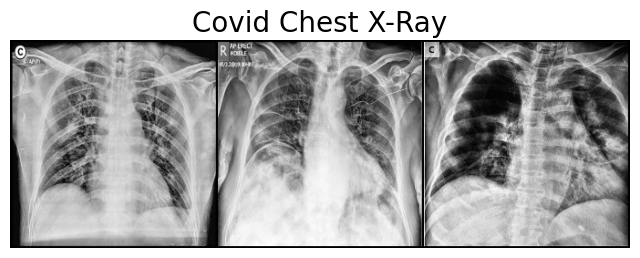

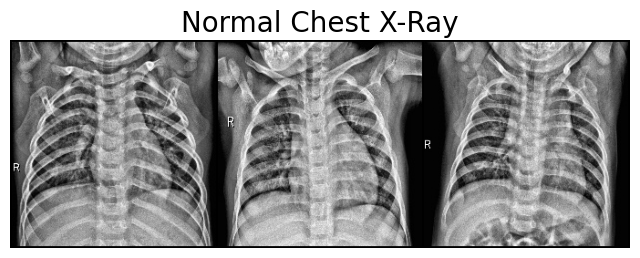

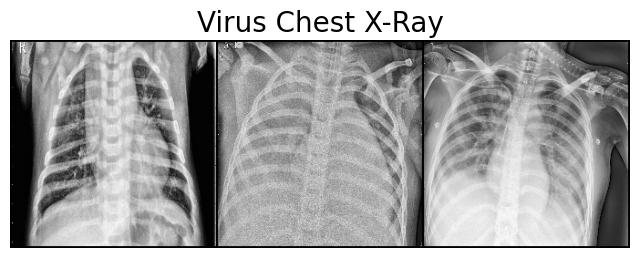

In [3]:
Covid = "/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/COVID_IEEE/train/Covid"  
Normal = "/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/COVID_IEEE/train/Normal"  
Virus = "/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/COVID_IEEE/train/Virus" 

Data_Visualization(Covid)
Data_Visualization(Normal)
Data_Visualization(Virus)

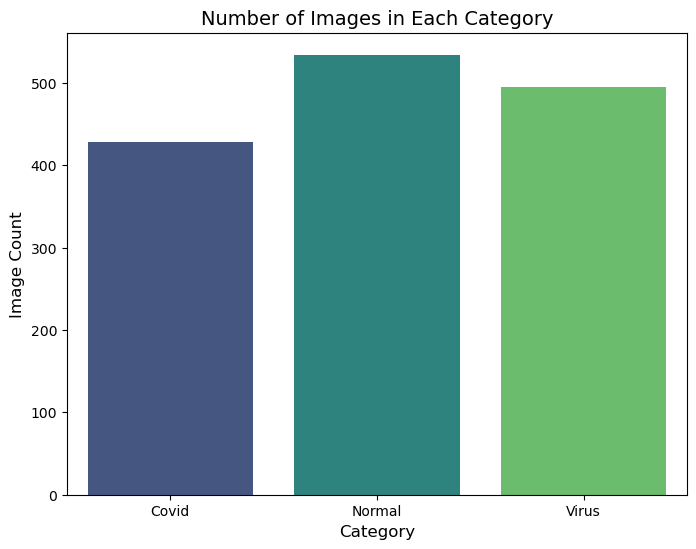

In [4]:
covid_image = list(Path(Covid).glob("*.jpeg"))
normal_image = list(Path(Normal).glob("*.jpeg"))
virus_image = list(Path(Virus).glob("*.jpeg"))

covid_count = len(covid_image)
normal_count = len(normal_image)
virus_count = len(virus_image)

# 正確的 DataFrame 建立方式
image_num = pd.DataFrame({'Category': ['Covid', 'Normal', 'Virus'],
                          'Count': [covid_count, normal_count, virus_count]})



plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=image_num, hue='Category', palette='viridis', legend=False)
plt.title('Number of Images in Each Category', fontsize=14)
plt.ylabel('Image Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

### Prepare data, set hyperparameters

In [5]:
PATH_train="/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/COVID_IEEE/train"
TRAIN =Path(PATH_train)
#Batch：每批丟入多少張圖片
batch_sizes = 8
#Learning Rate：學習率
LR = 0.0001
# transforms函數可以將圖片轉成(224,224)的像素，同時將圖片轉成Pytorch能讀取的tensor格式
img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

### Split training and validation sets

In [6]:
train_data = datasets.ImageFolder(TRAIN, transform=img_transform)
print(train_data.class_to_idx)
#切分70%當作訓練集、30%當作驗證集
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])
#Dataloader可以用Batch的方式訓練，可提高運算效率和減少記憶體使用量
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sizes,shuffle=True)

{'Covid': 0, 'Normal': 1, 'Virus': 2}


### CNN

In [7]:
# **定義 CNN 模型**
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1: input_shape=(3,224,224) --> (16, 220, 220)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # (16, 220, 220) --> (16, 110, 110)

        # Convolution 2: (16,110,110) --> (8,100,100)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=11, stride=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # (8,100,100) --> (8,50,50)

        # Fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8 * 50 * 50, 3)  # 8通道，50x50大小，最後分類為 2 類別

    def forward(self, x):
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x

# **初始化模型**
model = CNN_Model()

# **定義損失函數 & 優化器**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
#L2正則化會在損失函數中加入一項懲罰(weight_decay)，用來懲罰過大的權重值，從而防止過擬合
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# **檢查 GPU**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 載入模型的狀態字典
# model.load_state_dict(torch.load("cnn_model.pth"))

CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=20000, out_features=3, bias=True)
)

In [8]:
# **訓練函數**
epochs=10
batch_size = 8
train_loss_plt = []
val_loss_plt = []
train_accuracies = []
val_accuracies = []
all_labels = []
all_predictions = []
for epoch in range(epochs):
    model.train()  # 訓練模式
    train_loss = 0  # 記錄這個 epoch 內的總損失
    correct = 0  # 計算正確預測數
    total = 0  # 計算總樣本數

    # 進度條顯示
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # 梯度歸零，避免影響下一次更新
        outputs = model(images)  # 前向傳播，獲得預測結果
        loss = criterion(outputs, labels)  # 計算損失
        loss.backward()  # 反向傳播，計算梯度
        optimizer.step()  # 更新權重

        train_loss += loss.item()  # 累加 batch 損失
        _, predicted = outputs.max(1)  # 取得最大值的索引（即預測的標籤）
        total += labels.size(0)  # 更新目前處理過的總樣本數。
        correct += predicted.eq(labels).sum().item()  # 計算正確預測的數量

        # 更新進度條
        loop.set_postfix(loss=train_loss / (total / batch_size), acc=100. * correct / total)
    train_loss_1 = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    # 驗證模型
    model.eval()  # 驗證模式，關閉 dropout、batch normalization。
    valid_loss = 0
    correct = 0
    total = 0
    

    with torch.no_grad():  # 不計算梯度，加快運算
        for images, labels in valid_loader:  # 是驗證數據集的加載器
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()  # 累加這個 epoch 的總驗證損失

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            # all_labels.extend(labels.cpu().numpy())  
            # all_predictions.extend(predictions.cpu().numpy())
        
    # 紀錄結果
    val_loss_1 = valid_loss / len(valid_loader)
    val_accuracy = 100 * correct / total
    train_loss_plt.append(train_loss_1)
    train_accuracies.append(train_accuracy)
    val_loss_plt.append(val_loss_1)
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f} | "
          f"Valid Loss: {valid_loss / len(valid_loader):.4f} | "
          f"Valid Acc: {100. * correct / total:.2f}%\n")

# **儲存模型**
torch.save(model.state_dict(), "cnn_model.pth")
print("Model Saved!")

Epoch [1/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 1 | Train Loss: 0.9454 | Valid Loss: 0.5208 | Valid Acc: 86.30%



Epoch [2/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 2 | Train Loss: 0.4241 | Valid Loss: 0.2850 | Valid Acc: 91.32%



Epoch [3/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 3 | Train Loss: 0.2467 | Valid Loss: 0.2561 | Valid Acc: 89.50%



Epoch [4/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 4 | Train Loss: 0.2066 | Valid Loss: 0.2727 | Valid Acc: 90.64%



Epoch [5/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 5 | Train Loss: 0.1934 | Valid Loss: 0.2606 | Valid Acc: 88.58%



Epoch [6/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 6 | Train Loss: 0.1730 | Valid Loss: 0.2308 | Valid Acc: 89.95%



Epoch [7/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 7 | Train Loss: 0.1483 | Valid Loss: 0.2001 | Valid Acc: 92.47%



Epoch [8/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 8 | Train Loss: 0.1501 | Valid Loss: 0.2032 | Valid Acc: 93.84%



Epoch [9/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 9 | Train Loss: 0.1116 | Valid Loss: 0.2746 | Valid Acc: 92.47%



Epoch [10/10]:   0%|          | 0/128 [00:00<?, ?it/s]


Epoch 10 | Train Loss: 0.1131 | Valid Loss: 0.1976 | Valid Acc: 93.38%

Model Saved!


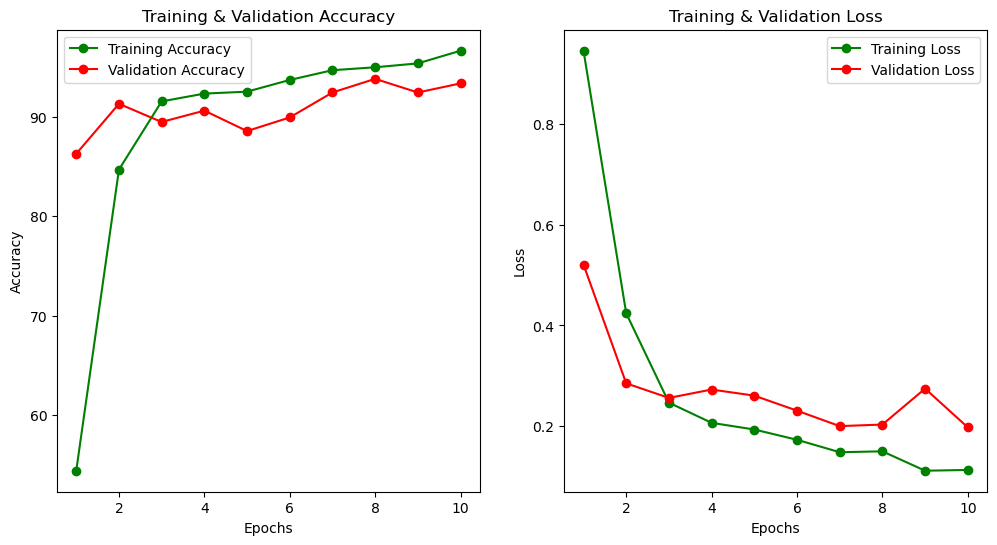

In [9]:
import matplotlib.pyplot as plt

# 設定 epochs
epochs = 10
epoch = range(1, epochs + 1)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(epoch, train_accuracies, 'go-', label='Training Accuracy')
ax[0].plot(epoch, val_accuracies, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch, train_loss_plt, 'g-o', label='Training Loss')
ax[1].plot(epoch, val_loss_plt, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


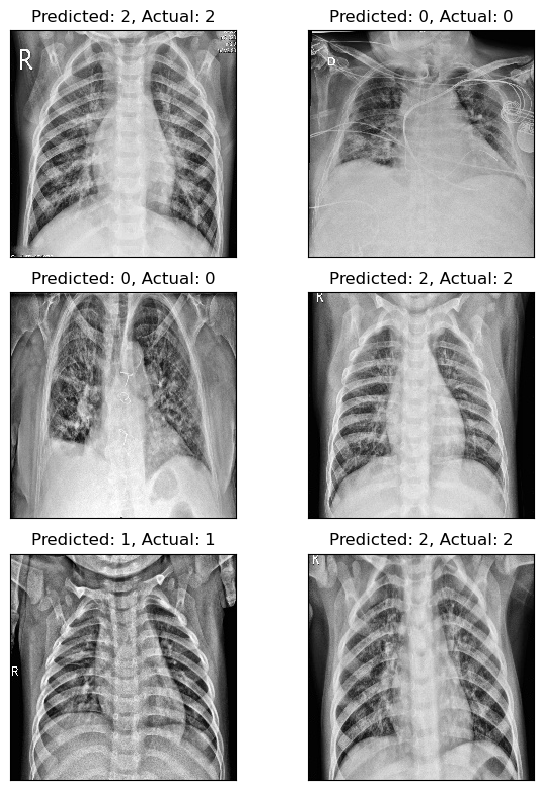

In [10]:
# 選擇要顯示的圖片數量
num_images = 6  

# 取得模型預測結果
model.eval()
with torch.no_grad():
    images, labels = next(iter(valid_loader))  # 取得一批驗證集的數據
    images, labels = images.to(device), labels.to(device)  # 移到 GPU 或 CPU
    outputs = model(images)  # 前向傳播
    _, predictions = torch.max(outputs, 1)  # 取得最大機率的類別

# 找出預測正確的index
correct_indices = np.where(predictions.cpu().numpy() == labels.cpu().numpy())[0]


plt.figure(figsize=(8, 8))
for i, idx in enumerate(correct_indices[:num_images]):  # 取前 num_images 張正確預測的圖
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0), cmap="gray", interpolation='none')  # 調整維度
    plt.title(f"Predicted: {predictions[idx].item()}, Actual: {labels[idx].item()}")
    plt.tight_layout()

plt.show()

# {'Covid': 0, 'Normal': 1, 'Virus': 2}

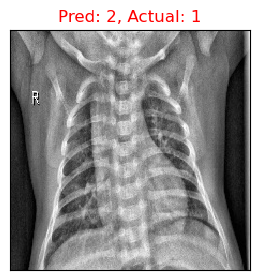

In [11]:
# 選擇要顯示的錯誤預測圖片數量
num_images = 6  

# 取得模型預測結果
model.eval()
with torch.no_grad():
    images, labels = next(iter(valid_loader))  # 取得一批驗證數據
    images, labels = images.to(device), labels.to(device)  # 移到 GPU 或 CPU
    outputs = model(images)  # 前向傳播
    _, predictions = torch.max(outputs, 1)  # 取得最大機率的類別

# 找出錯誤預測的index
incorrect_indices = np.where(predictions.cpu().numpy() != labels.cpu().numpy())[0]


plt.figure(figsize=(8, 8))
for i, idx in enumerate(incorrect_indices[:num_images]):  # 取前 num_images 張錯誤預測的圖
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0), cmap="gray", interpolation='none')  # 調整維度
    plt.title(f"Pred: {predictions[idx].item()}, Actual: {labels[idx].item()}", color='red')  # 標示錯誤
    plt.tight_layout()

plt.show()


# {'Covid': 0, 'Normal': 1, 'Virus': 2}

In [12]:
import os
import glob

# 測試資料夾
PATH_test = '/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/COVID_IEEE/test'
TEST =Path(PATH_test)

# 影像轉換
img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

def count_images(folder_path):
    """ 計算資料夾內有多少張圖片 """
    image_list = glob.glob(os.path.join(folder_path, "*.*"))  # 取得所有圖片
    return len(image_list), image_list  # 回傳圖片數量和檔案列表

def test_submit(model, image_list):
    """ 讀取所有圖片並進行模型預測 """
    model.eval()
    pred_label = []
    
    for img_path in tqdm(image_list, desc="Processing Images"):
        img = Image.open(img_path).convert('RGB')  # 讀取圖片並轉為 RGB
        img = img_transform(img).unsqueeze(0).to(device)  # 轉換並加 batch 維度

        with torch.no_grad(): 
            output = model(img)  # 取得預測結果
        pred = output.argmax(dim=1).item()  # 取得預測類別
        pred_label.append(pred)

    return pred_label

# 計算測試圖片數量
n_img, image_list = count_images(PATH_test)
print(f"總共有 {n_img} 張測試圖片")

# 進行模型預測
pred_label = test_submit(model, image_list)
print("預測完成！")

總共有 366 張測試圖片


Processing Images:   0%|          | 0/366 [00:00<?, ?it/s]

預測完成！


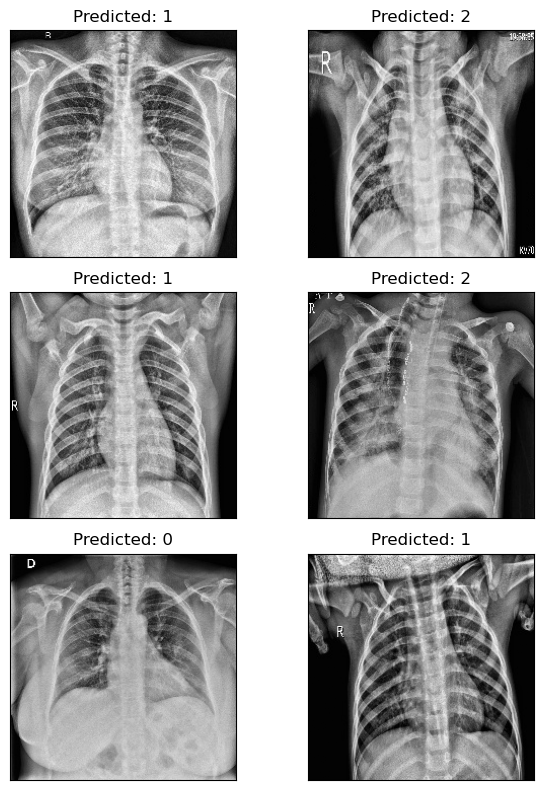

In [13]:
# 測試圖片資料夾
PATH_test = '/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/COVID_IEEE/test'

# 取得所有 .jpeg 圖片
image_paths = list(Path(PATH_test).glob("*.jpg"))

# 選擇前 6 張圖片
sample_images = image_paths[:6]

# 定義 PyTorch 影像轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整圖片大小
    transforms.ToTensor()  # 轉換為 Tensor 格式
])

# 讀取並轉換圖片
image_tensors = [transform(Image.open(img_path).convert("RGB")) for img_path in sample_images]


num_images = 6
plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_tensors[i].permute(1, 2, 0).numpy())  # 轉換格式
    plt.title(f"Predicted: {pred_label[i]}")
    plt.tight_layout()

plt.show()
# {'Covid': 0, 'Normal': 1, 'Virus': 2}

In [14]:
label = {0:'Covid', 1:'Normal', 2:'Virus'}

pred_label_type = [label[i] for i in pred_label]


submission_df = pd.DataFrame({
    'ID': range(len(pred_label)),  # Assuming IDs start from 1
    'Label': pred_label_type  # Adjust this if your labels need specific formatting
})

print(submission_df.head())

output_csv = '/Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/predicted.csv'
submission_df.to_csv(output_csv, index=False)
print(f"Submission CSV file generated at: {output_csv}")

   ID   Label
0   0  Normal
1   1   Virus
2   2  Normal
3   3   Virus
4   4   Covid
Submission CSV file generated at: /Users/hsinyu/Desktop/ML/Kaggle/Chest X-ray CNN Classification/predicted.csv
